In [394]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random


# Classes and some utilities

In [395]:
class BaseGrid:
    def __init__(self, rows, cols, cyclic=False):
        b = np.zeros((rows, cols), dtype='int')
        for i in range(b.shape[0]):
            for j in range(b.shape[1]):
                b[i][j] = i*b.shape[1]+j
        self.matrix = b
        self.rows = rows
        self.cols = cols
        self.cyclic = cyclic

    
    def iterate_boundaries(self):
        for i in range(self.rows if self.cyclic else self.rows-1):
            for j in range(self.cols):
                yield('h', i, j)
                
        for i in range(self.rows):
            for j in range(self.cols if self.cyclic else self.cols-1):
                yield('v', i, j)
        
        
    ALLOWED_TYPES = ['v', 'vertical', 'h', 'horizonal']
    def remove_boundary(self, boundary):
        type, row, col = boundary
        assert type in self.ALLOWED_TYPES, "type must be one of {}".format(ALLOWED_TYPES)
        
        if type == 'vertical' or type == 'v':
            row_range = range(self.rows)
            col_range = range(self.cols if self.cyclic else self.cols-1)
            
            assert row in row_range, "row must be between 0 and {}".format(len(row_range)-1)
            assert col in col_range, "vertical col must be between 0 and {}".format(len(col_range)-1)
            c1 = self.matrix[row][col]
            c2 = self.matrix[row][(col+1) % self.matrix.shape[1]]
            self.matrix[self.matrix == c2] = c1

        if type == 'horizontal' or type == 'h':
            row_range = range(self.rows if self.cyclic else self.rows-1)
            col_range = range(self.cols)
            
            assert row in row_range, "row must be between 0 and {}".format(len(row_range)-1)
            assert col in col_range, "vertical col must be between 0 and {}".format(len(col_range)-1)
            c1 = self.matrix[row][col]
            c2 = self.matrix[(row+1) % self.matrix.shape[0]][col]
            self.matrix[self.matrix == c2] = c1
    
    
    def blocks_dist(self):
        return np.bincount(np.bincount(self.matrix.flatten()))[1:]

    def __repr__(self):
        return str(self.matrix)

    def __len__(self):
        return self.matrix.size
        
    def apply_boundary_pct(self, p):
        for b in self.iterate_boundaries():
            if random.random() > p:
                self.remove_boundary(b)
    
    def join_cells(self, r1, c1, r2, c2):
        v1 = self.matrix[r1][c1]
        v2 = self.matrix[r2][c2]
        self.matrix[self.matrix==v2] = v1
        
        
    
class Row(BaseGrid):
    def __init__(self, N=10, cyclic=False):
        super(Row, self).__init__(1, N, cyclic=cyclic)
        
class Grid(BaseGrid):
    pass
        

    
class StraightRow(Row):    
    pass
    
class CyclicRow(Row):
    def __init__(self, N=10):
        super(CyclicRow, self).__init__(N, cyclic=True)
        
        
        
class StraightGrid(Grid):
    def __init__(self, rows, cols=None):
        if not cols:
            cols = rows
        super(StraightGrid, self).__init__(rows, cols)

class CyclicGrid(Grid):        
    def __init__(self, rows, cols=None):
        if not cols:
            cols = rows
        super(CyclicGrid, self).__init__(rows, cols, cyclic=True)
            
    

In [416]:
def calculate_block_size_dist_per_pe(cls, num_iters=100, boundary_step=0.05, N=10):
    pes = list(np.arange(0,1,boundary_step)) + [1]
    
    result = pd.DataFrame(index=pes, columns=[ "avg_num_{}".format(x) for x in np.arange(N)+1 ]+[ "avg_num_blocks" ])
    for pe in pes:
        block_size_dist = []
        
        for i in range(num_iters):
            r = cls(N)
            r.apply_boundary_pct(pe)

            blocks_dist = r.blocks_dist()
            block_size_dist.append(
                np.concatenate([blocks_dist, np.zeros(N)])[:N]
            )

        bsd = np.array(block_size_dist)
        for j in range(N):
            result["avg_num_{}".format(j+1)][pe] = np.mean(bsd[:,j])
        result["avg_num_blocks"][pe] = bsd.sum(axis=1).mean()
    
    for j in range(1,N+1):
        result["estimator_{}".format(j)] = N*result.index.values**2*(1-result.index.values)**(j-1)
    result["estimator_{}".format(N)] = (1-result.index.values)**(N-1)*((N-1)*result.index.values + 1)
    result["estimator_num_blocks"] = N*result.index.values + (1-result.index.values)**N

    return result
        
                

# A single cyclic row

- N - size of row.
- p - probability of a boundary to exist

We can estimate the expected (mean) number of blocks of size k in such a row with:

* k<n : E(k) = N*p^2*(1-p)^(k-1)
* k=N : E(k) = k*p*(1-p)^(k-1) + (1-p)^k

## Calculating result

In [417]:
def ei_expected_vs_actual(res, plot=False):
    ses = []
    for i in range(rows):
        actual = res["avg_num_{}".format(i+1)]
        estimate = res["estimator_{}".format(i+1)]
        se = np.abs(actual-estimate).mean()
        ses.append(se)
        
        if plot:
            plt.plot(res.index, actual)
            plt.plot(res.index, estimate)
            plt.title("E({}) , N={}".format(i+1, rows))
            plt.show()
    
    return np.mean(ses)
    
def sig_ei(res, n, plot=False):
    sig_ei = res[["avg_num_{}".format(i+1) for i in range(n)]].sum(axis=1)
    sig_ei_act_est = pd.DataFrame({"actual": sig_ei}, index=res.index)
    sig_ei_act_est["estimated"] = n*sig_ei_act_est.index.values + (1-sig_ei_act_est.index.values)**n

    if plot:
        plt.plot(sig_ei_act_est.index, sig_ei_act_est.actual)
        plt.plot(sig_ei_act_est.index, sig_ei_act_est.estimated)

    se = np.abs(sig_ei_act_est.actual-sig_ei_act_est.estimated).mean() / n
    return se

In [418]:
N = 8
res = calculate_block_size_dist_per_pe(CyclicRow, num_iters=1000, N=N)
rows = N

## Plotting all E(i) expected vs. actual

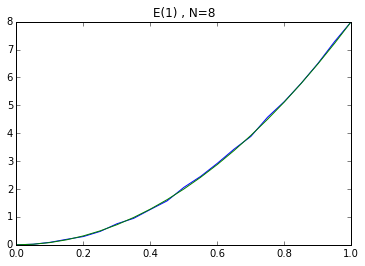

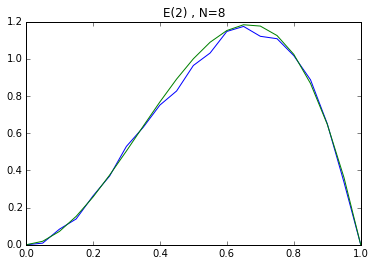

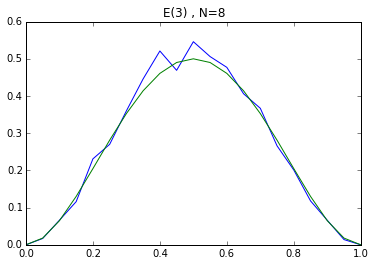

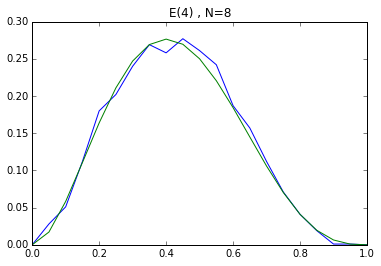

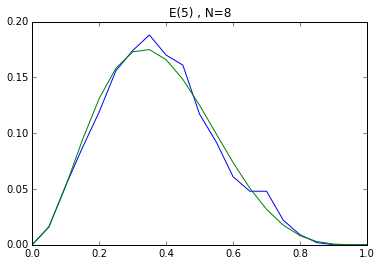

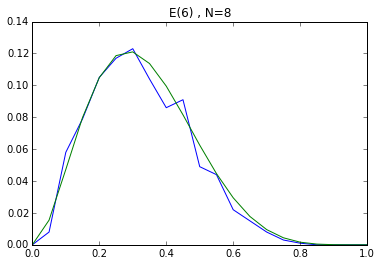

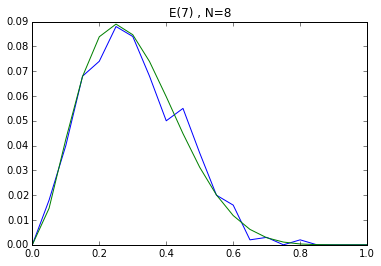

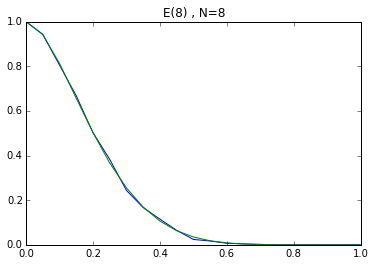

0.010446789300595226

In [419]:
ei_expected_vs_actual(res, plot=True)



## SIG( E(i) )
i = 1..N

Estimator: Np + (1-p)^N


In [420]:
sig_ei(res, N)

0.0030187941741071237

# A straight row
Estimators are for CyclicRow though...

In [425]:
N = 15
res = calculate_block_size_dist_per_pe(StraightRow, num_iters=100, N=N)
rows = N

## plotting E(i) actual vs. estimated

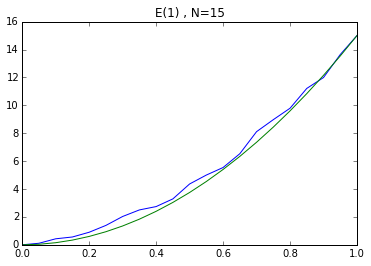

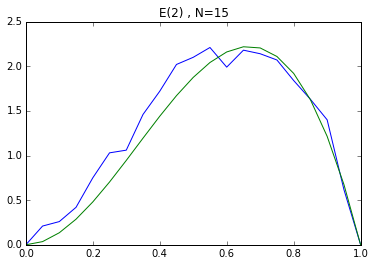

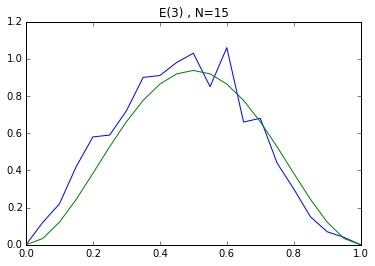

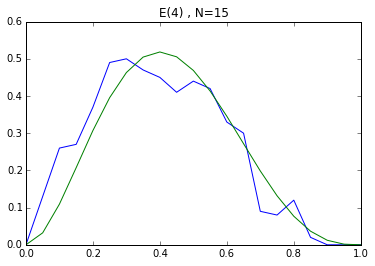

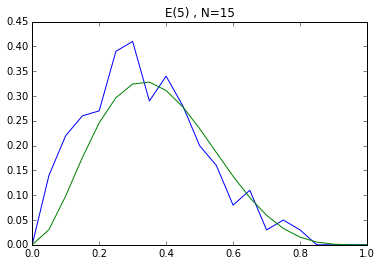

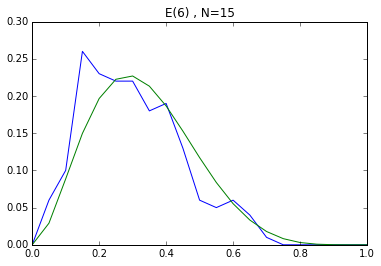

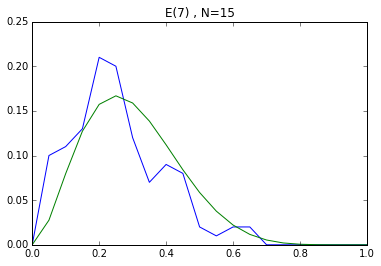

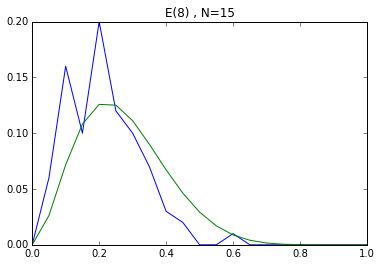

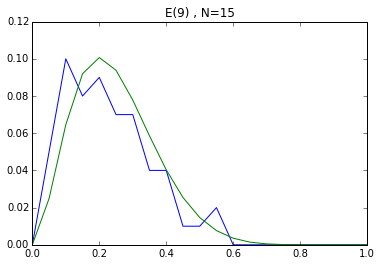

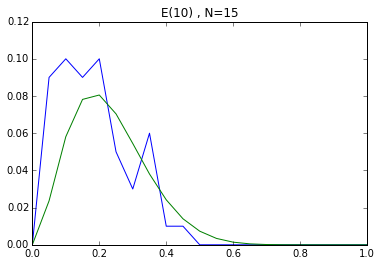

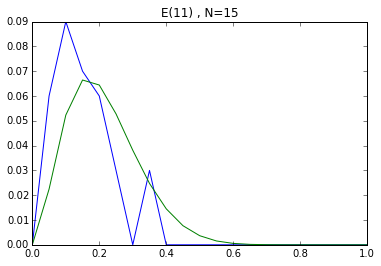

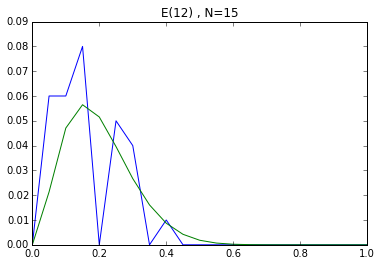

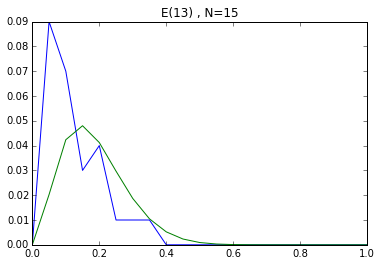

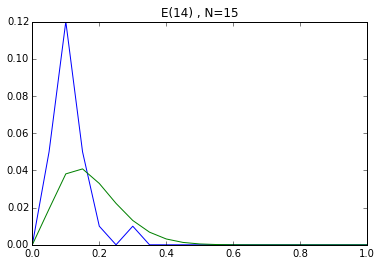

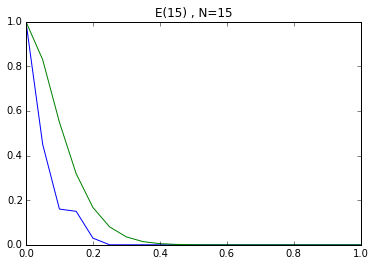

0.05345963343711959

In [426]:
ei_expected_vs_actual(res, plot=True)

In [409]:
sig_ei(res, N)

0.046032754216424804

# Difference between CyclicRow estimator and StraightRow actual result as N grows
(difference in num of blocks - SIG(E(i))

N = 10
N = 20
N = 30
N = 40
N = 50
N = 60
N = 70
N = 80
N = 90
N = 100
N = 150
N = 200
N = 250
N = 300
N = 350
N = 400
N = 450


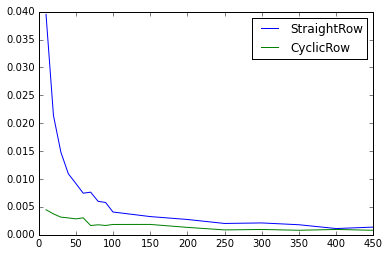

In [33]:
ns = list(range(10,100,10)) + list(range(100,500,50))

strght_actual = []
cyclc_actual = []
for n in ns:
    print("N = {}".format(n))
    res_sr = calculate_block_size_dist_per_pe(StraightRow, N=n, num_iters=250)
    se = sig_ei(res_sr, n)
    strght_actual.append(se)
    
    res_cr = calculate_block_size_dist_per_pe(CyclicRow, N=n, num_iters=250)
    se = sig_ei(res_cr, n)
    cyclc_actual.append(se)
    
plt.title('')
plt.plot(ns, strght_actual, label='StraightRow')
plt.plot(ns, cyclc_actual, label='CyclicRow')
plt.legend()

# A grid
Average block size in a NxN grid is estiamted to be:

In [36]:
ns = list(range(10,100,10))# + list(range(100,300,100))
pes = np.linspace(0.5,1, 5)

result = pd.DataFrame(index=ns, columns=[ 
        "strght_actual", "strght_est", "strght_diff", "strght_block_size", "cyclic_actual", "cyclic_est", "cyclic_diff", "cyclic_block_size"
    ])



for n in ns:
    print("N = {}".format(n))
    block_size_actuals = []
    block_size_ests = []
    block_sizes_mean = []
    
    for p in pes:
        block_sizes = []
        for i in range(20):
            g = CyclicGrid(n)
            g.apply_boundary_pct(p)
            block_sizes.append(n**2 / sum(g.blocks_dist()))
        
        actual_block_size = np.mean(block_sizes)
        est_block_size = (1/p**2)*( ((1-p)**n)*(n*p-p+2) + p - 2 )**2
        
#         block_size_diffs.append((actual_block_size - est_block_size)/actual_block_size)
        block_size_actuals.append(actual_block_size)
        block_size_ests.append(est_block_size)
        block_sizes_mean.append(actual_block_size)
        
    result.cyclic_actual[n] = np.mean(block_size_actuals)
    result.cyclic_est[n] = np.mean(block_size_ests)
    result.cyclic_diff[n] = result.cyclic_actual[n] - result.cyclic_est[n] #np.mean(np.abs(block_size_diffs))
    result.cyclic_block_size[n] = np.mean(block_sizes_mean)
    
    
    block_size_actuals = []
    block_size_ests = []
    block_sizes_mean = []
    for p in pes:
        block_sizes = []
        for i in range(20):
            g = StraightGrid(n)
            g.apply_boundary_pct(p)
            block_sizes.append(n**2 / sum(g.blocks_dist()))
        
        actual_block_size = np.mean(block_sizes)
        est_block_size = (1/p**2)*( ((1-p)**n)*(n*p-p+2) + p - 2 )**2
        
#         block_size_diffs.append((actual_block_size - est_block_size)/actual_block_size)
        block_size_actuals.append(actual_block_size)
        block_size_ests.append(est_block_size)
        block_sizes_mean.append(actual_block_size)
        
    result.strght_actual[n] = np.mean(block_size_actuals)
    result.strght_est[n] = np.mean(block_size_ests)
    result.strght_diff[n] = result.cyclic_actual[n] - result.cyclic_est[n] #np.mean(np.abs(block_size_diffs))
    result.strght_block_size[n] = np.mean(block_sizes_mean)

result        


N = 10
N = 20
N = 30
N = 40
N = 50
N = 60
N = 70
N = 80
N = 90


,strght_actual,strght_est,strght_diff,strght_block_size,cyclic_actual,cyclic_est,cyclic_diff,cyclic_block_size
10,2.619327,3.838368,-0.07722365,2.619327,3.761144,3.838368,-0.07722365,3.761144
20,3.073338,3.854141,-0.2826024,3.073338,3.571539,3.854141,-0.2826024,3.571539
30,3.162582,3.854168,-0.2229811,3.162582,3.631187,3.854168,-0.2229811,3.631187
40,3.227172,3.854168,-0.1436127,3.227172,3.710555,3.854168,-0.1436127,3.710555
50,3.338237,3.854168,-0.1831115,3.338237,3.671056,3.854168,-0.1831115,3.671056
60,3.37959,3.854168,-0.2135489,3.37959,3.640619,3.854168,-0.2135489,3.640619
70,3.422288,3.854168,-0.2570207,3.422288,3.597147,3.854168,-0.2570207,3.597147
80,3.437771,3.854168,-0.2534127,3.437771,3.600755,3.854168,-0.2534127,3.600755
90,3.505207,3.854168,-0.2309551,3.505207,3.623213,3.854168,-0.2309551,3.623213


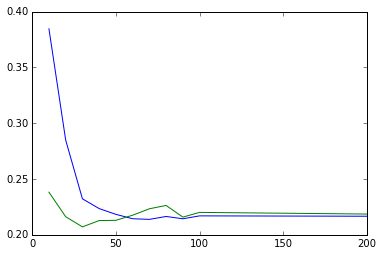

In [341]:
plt.plot(ns, result.strght_diff)
plt.plot(ns, result.cyclic_diff)

## Calculate actual and expected block sizes in a grid of N*N 

In [139]:
ns = list(range(10,100,10)) + list(range(100,300,100))
ps = np.linspace(0,1, 6)

def calc_grid_actual_vs_est(ns, ps, cls=CyclicGrid, num_iters=20):
    res = pd.Panel(items=['actual_size', 'est_size'], major_axis=ns, minor_axis=ps)
    
    for n in ns:
        for p in ps:
            block_sizes = []
            for i in range(num_iters):
                g = cls(n)
                g.apply_boundary_pct(p)
            
                block_sizes.append(n**2 / sum(g.blocks_dist()))
            res.loc['actual_size',n,p] = np.mean(block_sizes)
            res.loc['est_size',n,p] = (( (1-p)**n*(n*p-p+2)+p-2 ) / p )**2
    return res



In [140]:
res_cyclic = calc_grid_actual_vs_est(ns,ps,CyclicGrid)
print(res_cyclic['actual_size'])
print(res_cyclic['est_size'])

       0.0         0.2        0.4       0.6       0.8  1.0
10     100   92.500000  30.172619  4.613705  1.661123    1
20     400  297.333333  27.676207  4.441457  1.698044    1
30     900  520.178571  29.581618  4.278136  1.675471    1
40    1600  475.333333  29.470633  4.360267  1.670228    1
50    2500  614.972527  30.211155  4.191131  1.660377    1
60    3600  528.359141  28.040414  4.371819  1.670960    1
70    4900  656.721154  29.547660  4.356369  1.658958    1
80    6400  536.798887  30.061021  4.349586  1.658934    1
90    8100  553.611015  29.902266  4.291919  1.658384    1
100  10000  561.466902  29.407398  4.291189  1.661604    1
200  40000  553.470987  29.231660  4.259161  1.660820    1
     0.0        0.2        0.4       0.6       0.8  1.0
10   NaN  48.440076  15.329945  5.438411  2.249996    1
20   NaN  75.093538  15.992981  5.444443  2.250000    1
30   NaN  80.133297  15.999940  5.444444  2.250000    1
40   NaN  80.882805  16.000000  5.444444  2.250000    1
50   NaN  80

In [141]:
res_strght = calc_grid_actual_vs_est(ns,ps,StraightGrid)
print(res_strght['actual_size'])
print(res_strght['est_size'])

       0.0         0.2        0.4       0.6       0.8  1.0
10     100   72.500000  18.107864  3.163665  1.544919    1
20     400  257.333333  20.816824  3.640771  1.601360    1
30     900  306.000000  22.884013  3.805959  1.634008    1
40    1600  393.619048  24.136117  3.964239  1.646062    1
50    2500  393.650794  25.260118  4.000362  1.641785    1
60    3600  400.555195  26.216861  4.073236  1.643137    1
70    4900  411.988885  26.257643  4.125672  1.646093    1
80    6400  394.848636  26.621504  4.106182  1.652890    1
90    8100  469.248060  26.924933  4.138793  1.647097    1
100  10000  461.886364  27.350467  4.148886  1.649254    1
200  40000  531.577033  28.653812  4.230335  1.654244    1
     0.0        0.2        0.4       0.6       0.8  1.0
10   NaN  48.440076  15.329945  5.438411  2.249996    1
20   NaN  75.093538  15.992981  5.444443  2.250000    1
30   NaN  80.133297  15.999940  5.444444  2.250000    1
40   NaN  80.882805  16.000000  5.444444  2.250000    1
50   NaN  80

## Compare actual numbers for Cyclic vs. Straight

       0.0         0.2        0.4       0.6       0.8  1.0
10     100   92.500000  30.172619  4.613705  1.661123    1
20     400  297.333333  27.676207  4.441457  1.698044    1
30     900  520.178571  29.581618  4.278136  1.675471    1
40    1600  475.333333  29.470633  4.360267  1.670228    1
50    2500  614.972527  30.211155  4.191131  1.660377    1
60    3600  528.359141  28.040414  4.371819  1.670960    1
70    4900  656.721154  29.547660  4.356369  1.658958    1
80    6400  536.798887  30.061021  4.349586  1.658934    1
90    8100  553.611015  29.902266  4.291919  1.658384    1
100  10000  561.466902  29.407398  4.291189  1.661604    1
200  40000  553.470987  29.231660  4.259161  1.660820    1
     0.0         0.2        0.4       0.6       0.8  1.0
10     0   20.000000  12.064755  1.450040  0.116204    0
20     0   40.000000   6.859384  0.800686  0.096684    0
30     0  214.178571   6.697605  0.472177  0.041463    0
40     0   81.714286   5.334516  0.396028  0.024165    0
50     

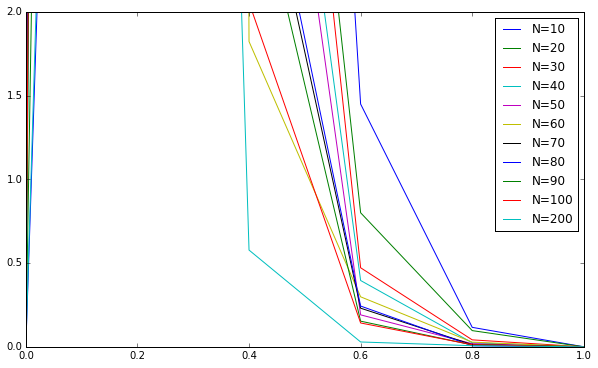

In [247]:
cyc_strght_diff = res_cyclic['actual_size'] - res_strght['actual_size']
print(res_cyclic['actual_size'])
print(cyc_strght_diff)


plt.figure(figsize=(10,6))

for n in cyc_strght_diff.index.values:
    plt.plot(cyc_strght_diff.columns.values, cyc_strght_diff.loc[n,:], label="N={}".format(n))

axes = plt.gca()
axes.set_ylim([0,2])
plt.legend()

## Compare actual and expected for a cyclic grid

In [248]:
act_est_diff = res_cyclic['actual_size'] - res_cyclic['est_size']
print(res_cyclic['actual_size'])
print(res_cyclic['est_size'])
print(act_est_diff)


# plt.figure(figsize=(10,6))

# for n in cyc_strght_diff.index.values:
#     plt.plot(cyc_strght_diff.columns.values, cyc_strght_diff.loc[n,:], label="N={}".format(n))

# axes = plt.gca()
# axes.set_ylim([0,2])
# plt.legend()

       0.0         0.2        0.4       0.6       0.8  1.0
10     100   92.500000  30.172619  4.613705  1.661123    1
20     400  297.333333  27.676207  4.441457  1.698044    1
30     900  520.178571  29.581618  4.278136  1.675471    1
40    1600  475.333333  29.470633  4.360267  1.670228    1
50    2500  614.972527  30.211155  4.191131  1.660377    1
60    3600  528.359141  28.040414  4.371819  1.670960    1
70    4900  656.721154  29.547660  4.356369  1.658958    1
80    6400  536.798887  30.061021  4.349586  1.658934    1
90    8100  553.611015  29.902266  4.291919  1.658384    1
100  10000  561.466902  29.407398  4.291189  1.661604    1
200  40000  553.470987  29.231660  4.259161  1.660820    1
     0.0        0.2        0.4       0.6       0.8  1.0
10   NaN  48.440076  15.329945  5.438411  2.249996    1
20   NaN  75.093538  15.992981  5.444443  2.250000    1
30   NaN  80.133297  15.999940  5.444444  2.250000    1
40   NaN  80.882805  16.000000  5.444444  2.250000    1
50   NaN  80

(0, 20)

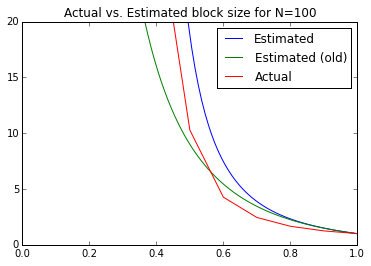

In [393]:
n=100
def avg_size(n,p):
    return -1/p*((1-p)**n*(n*p-p+2)+p-2)

def int_p(p, n):
    avgs = avg_size(n,p)
    int_acct_for = (avgs+1)**2
    extra_ext = avgs**2 - 1
    extra_int = (avgs - 1)**2
    return (p*(int_acct_for + extra_ext + extra_int) - extra_ext) / (int_acct_for)
#     return (act_p*((avg_size(n,act_p)+1)**2 + avg_size(n,act_p)**2 - 1 + 0.5*(avg_size(n,act_p)-1)**2) - (avg_size(n,act_p)**2 - 1)) / ((avg_size(n,act_p)+1)**2 + 0.5*(avg_size(n,act_p)-1)**2 )


#res_tmp = calc_grid_actual_vs_est(ns,np.linspace(0,1,11))

ps = np.linspace(0,1.0,100)
est = [ (( (1-p)**n*(n*p-p+2)+p-2 ) / p )**2 for p in [ int_p(pp, n) for pp in ps] ]
est2 = [ (( (1-p)**n*(n*p-p+2)+p-2 ) / p )**2 for p in ps ]


act_ps = res_tmp['actual_size'].columns
act = res_tmp['actual_size'].loc[100,:]

plt.plot(ps, est, label='Estimated')
plt.plot(ps, est2, label='Estimated (old)')
plt.plot(act_ps, act, label='Actual')
plt.title("Actual vs. Estimated block size for N=100")
plt.legend()

axes = plt.gca()
axes.set_ylim([0,20])


(0, 1)

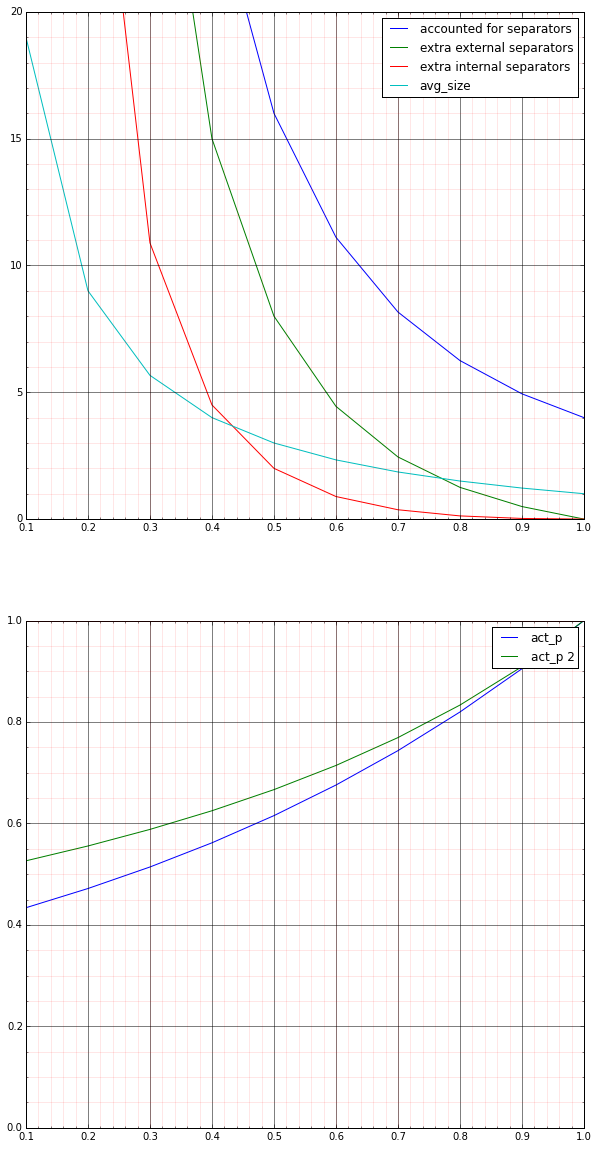

In [331]:
# ES = Extra separators = bl(bl - 1)
def avg_size(n,p):
    return -1/p*((1-p)**n*(n*p-p+2)+p-2)

ps = np.linspace(0,1,11)
n=100
acc_for = [ (avg_size(n,p)+1)**2  for p in ps ]
ext_ex = [ avg_size(n,p)**2 - 1 for p in ps ]
ext_int = [ 0.5*(avg_size(n,p)-1)**2 for p in ps]

avg_bl_size = [ avg_size(n,p) for p in ps]

plt.figure(figsize=(10,20))
plt.subplot(2,1,1)

plt.plot(ps,acc_for, label='accounted for separators')
plt.plot(ps,ext_ex, label='extra external separators')
plt.plot(ps,ext_int, label='extra internal separators')
plt.plot(ps,avg_bl_size, label='avg_size')


plt.legend()
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='r', linestyle='-', alpha=0.2)
plt.minorticks_on()

axes = plt.gca()
axes.set_ylim([0,20])


plt.subplot(2,1,2)
act_p = [ (p*(avg_size(n,p)+1)**2 + avg_size(n,p)**2 - 1) / ((avg_size(n,p)+1)**2 + avg_size(n,p)**2 - 1 +  0.5*(avg_size(n,p)-1)**2) for p in ps]
act_p2 = [ (p*(avg_size(n,p)+1)**2 + avg_size(n,p)**2 - 1) / ((avg_size(n,p)+1)**2 + avg_size(n,p)**2 - 1)  for p in ps]
p = [ (act_p*((avg_size(n,act_p)+1)**2 + avg_size(n,act_p)**2 - 1) - (avg_size(n,act_p)**2 - 1)) / ((avg_size(n,act_p)+1)**2) for act_p in ps ]

plt.plot(ps, act_p, label='act_p')
plt.plot(ps, act_p2, label='act_p 2')

plt.legend()
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='r', linestyle='-', alpha=0.2)
plt.minorticks_on()

axes = plt.gca()
axes.set_ylim([0,1])


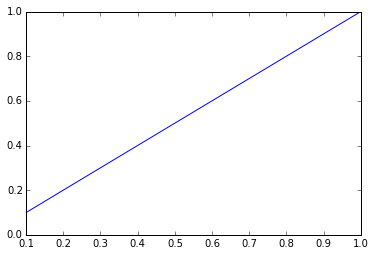

In [285]:
ps = np.linspace(0,1,11)
p_dashs = [ p_dash(p) for p in ps]

plt.plot(ps,p_dashs)

In [280]:
def p_dash(p,n=100):
    return (p*2*n*(n-1)) / (2*n*(n-1) + 0.5*( -1/p*((1-p)**n*(n*p-p+2)+p-2) - 1)**2)


In [286]:
print(ps)
print(p_dashs)

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]
[nan, 0.099188740747417917, 0.19967728923131647, 0.29983510751662951, 0.39990911156555331, 0.49994950005049993, 0.59997306518225901, 0.69998701322795498, 0.79999494952683381, 0.89999887766694397, 1.0]


## plot CyclicGrid differences

In [127]:
def plot_actual_est_block_size_diff(res):
    plt.figure(figsize=(10,10))
    for p in res['actual_size'].columns:
        plt.plot(res['actual_size'].index.values, res['actual_size'].loc[:,p] , label="{} act".format(p), color=plt.cm.Paired(2*p-1))
        plt.plot(res['actual_size'].index.values, res['est_size'].loc[:,p]    , label="{} est".format(p), color=plt.cm.Paired(2*p-1))
    plt.legend()
    plt.xlabel('N')
    plt.ylabel('Block Size')
    plt.title('Actual and expected block sizes in a CyclicGrid')

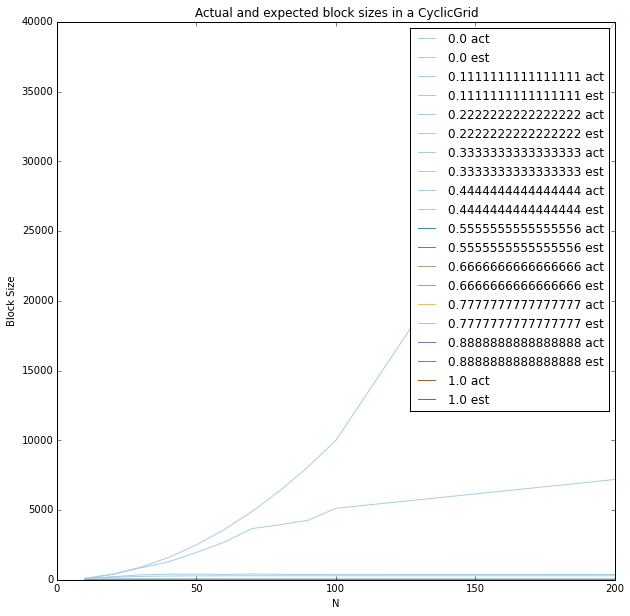

In [128]:
plot_actual_est_block_size_diff(res_cyclic)

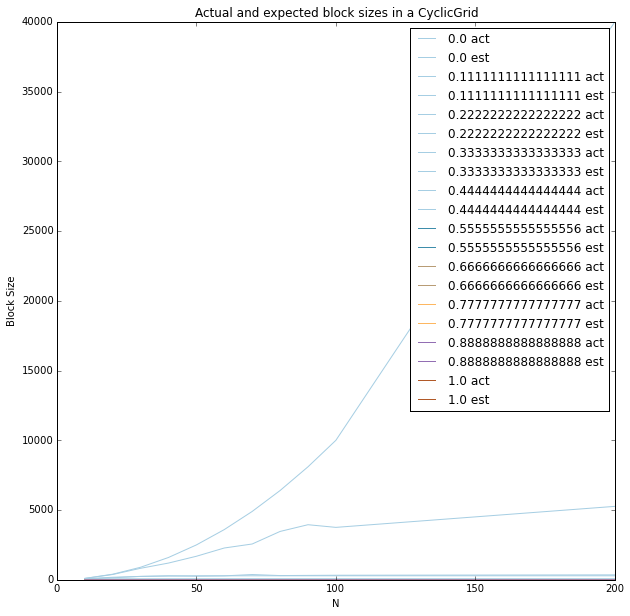

In [129]:
plot_actual_est_block_size_diff(res_strght)

## Compare CyclicGrid to StraightGrid

## calc the diff in % for N=100 (seems constant anyway)

0.500   -0.119932
0.625    0.339650
0.750    0.396551
0.875    0.238730
1.000    0.000000
Name: 100, dtype: float64


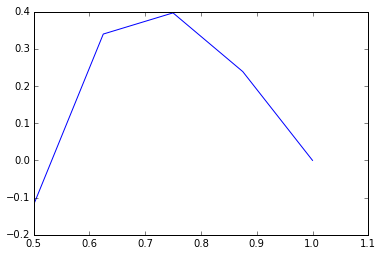

In [117]:
tmp = (res['est_size'].loc[100,:] - res['actual_size'].loc[100,:]) / res['actual_size'].loc[100,:]
print(tmp)
plt.plot(pes, tmp)

0.500   -1.226481
0.625    1.227115
0.750    0.788751
0.875    0.318581
1.000    0.000000
Name: 100, dtype: float64


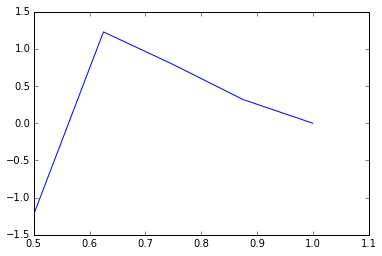

In [118]:
tmp = res['est_size'].loc[100,:] - res['actual_size'].loc[100,:]
print(tmp)
plt.plot(pes,tmp)

# the same for StraightGrid

In [119]:
res = calc_grid_actual_vs_est(ns,ps,StraightGrid)
print(res['actual_size'])
print(res['est_size'])


        0.500     0.625     0.750     0.875  1.000
10   6.728987  2.888721  1.834534  1.287551      1
20   8.366660  3.200090  1.904092  1.316779      1
30   8.478461  3.335199  1.905450  1.309832      1
40   8.683830  3.444424  1.936491  1.319902      1
50   9.209761  3.415527  1.953921  1.323790      1
60   9.044309  3.496299  1.942121  1.328069      1
70   9.564150  3.512202  1.933947  1.325098      1
80   9.445941  3.539597  1.955580  1.328918      1
90   9.546064  3.530950  1.967752  1.328945      1
100  9.669400  3.559685  1.961148  1.331150      1
200  9.899986  3.590991  1.978204  1.331057      1
        0.500     0.625     0.750     0.875  1.000
10   8.923989  4.837048  2.777741  1.653061      1
20   8.999868  4.840000  2.777778  1.653061      1
30   9.000000  4.840000  2.777778  1.653061      1
40   9.000000  4.840000  2.777778  1.653061      1
50   9.000000  4.840000  2.777778  1.653061      1
60   9.000000  4.840000  2.777778  1.653061      1
70   9.000000  4.840000  2.7777

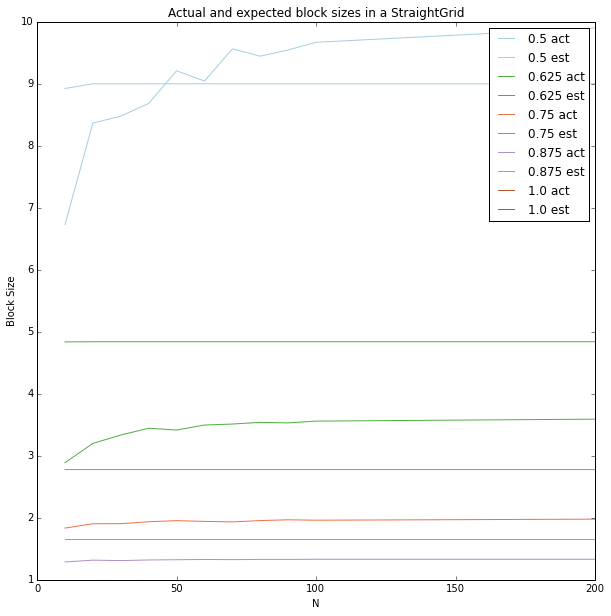

In [120]:
plt.figure(figsize=(10,10))
for p in res['actual_size'].columns:
    plt.plot(res['actual_size'].index.values, res['actual_size'].loc[:,p] , label="{} act".format(p), color=plt.cm.Paired(2*p-1))
    plt.plot(res['actual_size'].index.values, res['est_size'].loc[:,p]    , label="{} est".format(p), color=plt.cm.Paired(2*p-1))
plt.legend()
plt.xlabel('N')
plt.ylabel('Block Size')
plt.title('Actual and expected block sizes in a StraightGrid')

0.500   -0.069229
0.625    0.359671
0.750    0.416404
0.875    0.241829
1.000    0.000000
Name: 100, dtype: float64


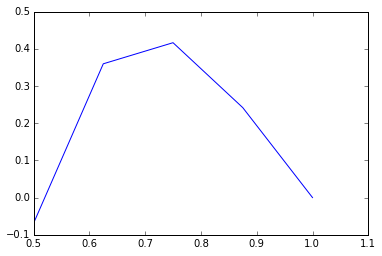

In [121]:
tmp = (res['est_size'].loc[100,:] - res['actual_size'].loc[100,:]) / res['actual_size'].loc[100,:]
print(tmp)
plt.plot(pes, tmp)

0.500   -0.669400
0.625    1.280315
0.750    0.816630
0.875    0.321911
1.000    0.000000
Name: 100, dtype: float64


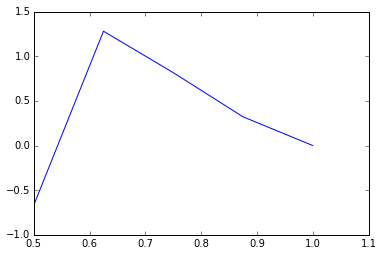

In [122]:
tmp = res['est_size'].loc[100,:] - res['actual_size'].loc[100,:]
print(tmp)
plt.plot(pes,tmp)

In [368]:
(4*3+5+7*6+80+40+24)/27




7.518518518518518